In [1]:
!pip install fuzzywuzzy
!pip install wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from fuzzywuzzy import fuzz, process
import re
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
from collections import Counter


C:\Users\renal\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv('Food_Inspections_20250216.csv')

In [3]:
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,1106427,BLOOMING BUD DAYCARE,BLOOMING BUD DAYCARE,2215789.0,Daycare Combo 1586,Risk 1 (High),5715 N LINCOLN AVE,CHICAGO,IL,60659.0,03/07/2013,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.985390,-87.698734,"(41.98538950526786, -87.69873407149943)"
1,2608378,Babas Halal,Babas Halal,2684170.0,Restaurant,Risk 1 (High),7901 S DAMEN AVE,CHICAGO,IL,60620.0,12/03/2024,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.750189,-87.672986,"(41.750189342293375, -87.67298583977204)"
2,1106406,FIRST ZABIHA MEAT BAZAAR,FIRST ZABIHA MEAT BAZAAR,2232559.0,Grocery Store,Risk 2 (Medium),2907 W DEVON AVE,CHICAGO,IL,60659.0,02/20/2013,License,Fail,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.997401,-87.702385,"(41.99740137039031, -87.70238538227812)"
3,2609909,HAPPY MARKET,HAPPY MARKET,2912802.0,Grocery Store,Risk 2 (Medium),2334 S WENTWORTH AVE,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.849954,-87.632094,"(41.84995400192252, -87.63209419559098)"
4,2609927,SAT KAIVAL FOOD INC/SUBWAY,SAT KAIVAL FOOD INC/SUBWAY,2728400.0,Restaurant,Risk 1 (High),1916 S STATE ST,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.856053,-87.627311,"(41.85605269621059, -87.62731125804903)"


In [4]:
df.shape
df.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Results             object
Violations          object
Latitude           float64
Longitude          float64
Location            object
dtype: object

# Convert zip into categorical type

In [5]:
df['Zip'] = df['Zip'].astype(str)

# Assess data missing

In [6]:
#After conversion to object, null values will be converted to nan. Remove the nan so isnull function is still correct
df["Zip"] = df["Zip"].replace("nan", None)

missing_values = df.isnull().sum()
missing_values

Inspection ID          0
DBA Name               0
AKA Name            2426
License #             18
Facility Type       5197
Risk                  88
Address                0
City                 164
State                 58
Zip                   39
Inspection Date        0
Inspection Type        1
Results                0
Violations         79652
Latitude             978
Longitude            978
Location             978
dtype: int64

# Assess Uniqueness 

In [7]:
unique_counts = df.nunique()
print(unique_counts)


Inspection ID      287237
DBA Name            33304
AKA Name            31703
License #           46274
Facility Type         519
Risk                    4
Address             30905
City                   86
State                   6
Zip                   127
Inspection Date      3813
Inspection Type       110
Results                 7
Violations         206183
Latitude            18493
Longitude           18493
Location            18493
dtype: int64


# Categorical describe

In [8]:
# Generate profiling summary
def get_sample_values(series):
    unique_vals = series.dropna().unique()
    return ', '.join(map(str, unique_vals[:2]))  # Strictly show only first 3 values

profile_data = []
for col in df.columns:
    profile_data.append({
        'Column name': col,
        'Missing Values': f"{df[col].isna().mean()*100:.3f}%",  # Updated to 3 decimal places
        'Unique Values': df[col].nunique(),
        'Sample Values': get_sample_values(df[col])
    })

profile_df = pd.DataFrame(profile_data)

In [9]:
profile_df.to_csv('profile_df.csv')

# City

In [10]:
print(df["City"].value_counts())

City
CHICAGO         286102
Chicago            448
chicago            150
CCHICAGO            59
SCHAUMBURG          28
                 ...  
ALGONQUIN            1
GRIFFITH             1
NEW YORK             1
NEW HOLSTEIN         1
GRAYSLAKE            1
Name: count, Length: 86, dtype: int64


Removed 0 empty/NaN entries


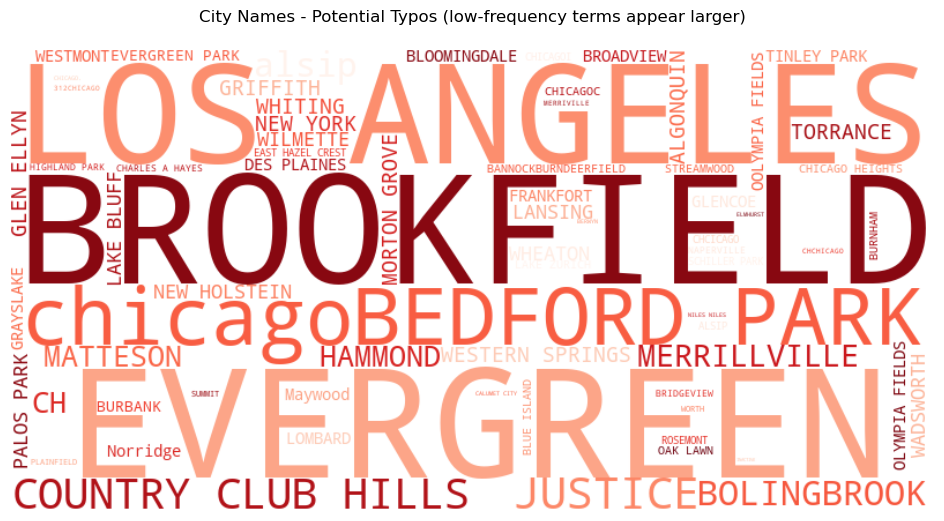


Term frequencies (potential typos in red):
BROOKFIELD: 1
EVERGREEN: 1
LOS ANGELES: 1
chicagoBEDFORD PARK: 1
JUSTICE: 1
COUNTRY CLUB HILLS: 1
BOLINGBROOK: 1
alsip: 1
MERRILLVILLE: 1
MATTESON: 1
HAMMOND: 1
CH: 1
WESTERN SPRINGS: 1
TORRANCE: 1
WHITING: 1
GLEN ELLYN: 1
MORTON GROVE: 1
ALGONQUIN: 1
GRIFFITH: 1
NEW YORK: 1
NEW HOLSTEIN: 1
WADSWORTH: 1
LANSING: 1
WILMETTE: 1
WHEATON: 1
PALOS PARK: 1
LAKE BLUFF: 1
BLOOMINGDALE: 1
Norridge: 1
TINLEY PARK: 1
LOMBARD: 1
WESTMONT: 1
OOLYMPIA FIELDS: 1
DES PLAINES: 1
OLYMPIA FIELDS: 1
GLENCOE: 1
FRANKFORT: 1
BROADVIEW: 1
Maywood: 1
GRAYSLAKE: 1
BURBANK: 2
EVERGREEN PARK: 2
BANNOCKBURNDEERFIELD: 2
STREAMWOOD: 2
LAKE ZURICH: 2
BLUE ISLAND: 2
BURNHAM: 2
OAK LAWN: 2
CHICAGOC: 2
CHICAGO HEIGHTS: 2
EAST HAZEL CREST: 3
ALSIP: 3
ROSEMONT: 3
SCHILLER PARK: 3
CHCICAGO: 3
CHICAGOI: 3
NAPERVILLE: 4
HIGHLAND PARK: 4
BRIDGEVIEW: 4
CHARLES A HAYES: 4
PLAINFIELD: 5
WORTH: 5
SUMMIT: 5
312CHICAGO: 6
CHCHICAGO: 6
MERRIVILLE: 6
CHICAGO.: 7
CALUMET CITY: 7
NILES NILES

In [11]:


# Step 1: Clean the data - drop NaN/empty strings and convert to string
df_clean = df.copy()
df_clean['City'] = df_clean['City'].astype(str)  # Convert all to strings
df_clean['City'] = df_clean['City'].str.strip()  # Remove whitespace
df_clean = df_clean[df_clean['City'] != '']  # Drop empty strings

print(f"Removed {len(df) - len(df_clean)} empty/NaN entries")

# Step 2: Count term frequencies
term_counts = Counter(df_clean['City'])

# Step 3: Create size mapping - make rare terms appear larger
size_map = {term: max(1, 10-count) for term, count in term_counts.items()}

# Step 4: Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',  # Red scale highlights potential issues
    prefer_horizontal=0.9
).generate_from_frequencies(size_map)

# Step 5: Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('City Names - Potential Typos (low-frequency terms appear larger)', pad=20)
plt.show()

# Step 6: Print frequency table
print("\nTerm frequencies (potential typos in red):")
for term, count in sorted(term_counts.items(), key=lambda x: x[1]):
    color = '\033[91m' if count <= 1 else '\033[0m'  # Red for single occurrences
    print(f"{color}{term}: {count}\033[0m")

TOP 20 CITIES BY FREQUENCY:
 1. CHICAGO        : 205110 occurrences
 2. Chicago        : 289 occurrences
 3. chicago        : 103 occurrences
 4. CCHICAGO       : 48 occurrences
 5. CHicago        : 15 occurrences
 6. CHICAGO.       : 6 occurrences
 7. CHICAGOCHICAGO : 6 occurrences
 8. 312CHICAGO     : 4 occurrences
 9. CHICAGOO       : 4 occurrences
10. CHCHICAGO      : 3 occurrences
11. SUMMIT         : 2 occurrences
12. CH             : 1 occurrences
13. CHICAGOC       : 1 occurrences
14. CHICAGOI       : 1 occurrences
15. CHARLES A HAYES: 1 occurrences
16. CHCICAGO       : 1 occurrences


C:\Users\renal\AppData\Local\Temp\ipykernel_12196\852798223.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', pad=0.03)


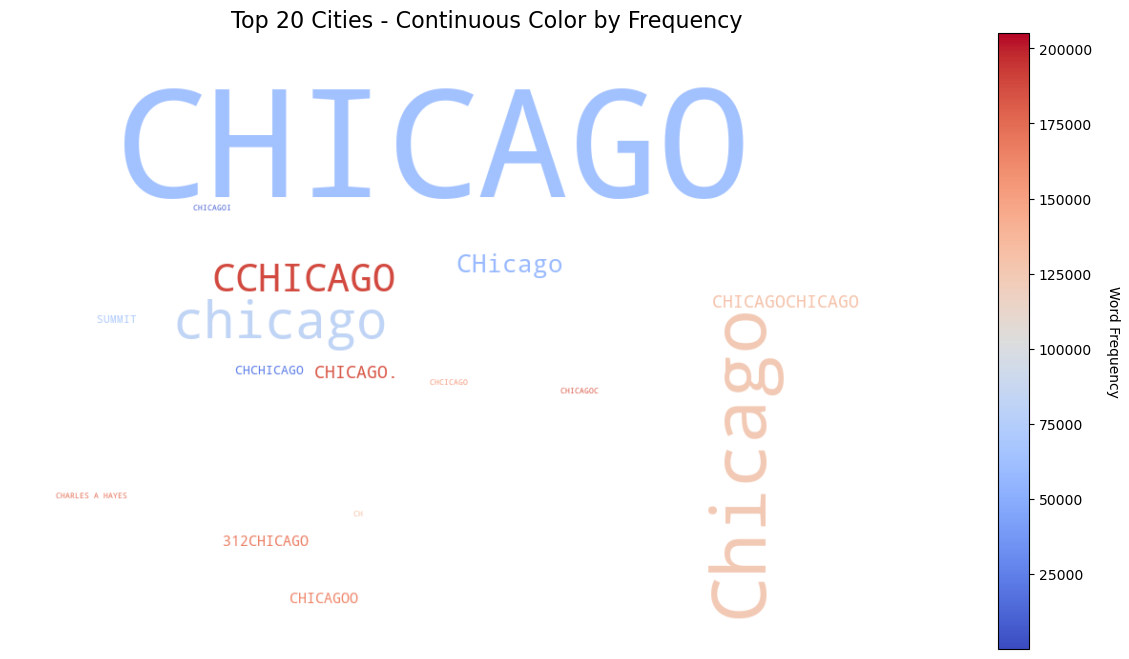

In [12]:

# Clean data
df_clean = df.dropna().astype(str)
df_clean['City'] = df_clean['City'].str.strip()
df_clean = df_clean[df_clean['City'] != '']

# Count frequencies and get top 20
term_counts = Counter(df_clean['City'])
top_20 = dict(term_counts.most_common(20))

# Create continuous color gradient (blue to red)
colors = plt.cm.coolwarm(np.linspace(0, 1, 256))
color_map = mcolors.LinearSegmentedColormap.from_list("coolwarm", colors)

# Normalize frequencies for color mapping
max_freq = max(top_20.values())
min_freq = min(top_20.values())
norm = mcolors.Normalize(vmin=min_freq, vmax=max_freq)

def color_func(word, font_size, position, orientation, **kwargs):
    freq = top_20[word]
    # Get RGB color from colormap based on normalized frequency
    rgba = color_map(norm(freq))
    return mcolors.rgb2hex(rgba)

# Generate word cloud
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    max_words=20,
    prefer_horizontal=0.9,
    colormap='coolwarm'  # Built-in continuous colormap
).generate_from_frequencies(top_20)

# Display
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 20 Cities - Continuous Color by Frequency', pad=20, fontsize=16)

# Add colorbar for reference
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', pad=0.03)
cbar.set_label('Word Frequency', rotation=270, labelpad=20)

# Print frequency table with color indicators
print("\033[1mTOP 20 CITIES BY FREQUENCY:\033[0m")
for i, (city, count) in enumerate(sorted(top_20.items(), key=lambda x: -x[1]), 1):
    # Get normalized color value
    norm_val = norm(count)
    # Get RGB color
    rgba = color_map(norm_val)
    # Convert to ANSI color (approximation)
    ansi_color = f"\033[38;2;{int(rgba[0]*255)};{int(rgba[1]*255)};{int(rgba[2]*255)}m"
    print(f"{i:2}. {ansi_color}{city:15}\033[0m: {count} occurrences")

plt.show()

###### 

In [13]:
# 1. Define known valid city names
KNOWN_VALID_CITIES = {
    'CHICAGO', 'OLYMPIA FIELDS', 'MERRILLVILLE', 'EVERGREEN', 'BEDFORD PARK', 'WADSWORTH','BANNOCKBURN DEERFIELD'}

def clean_city_name(city):
    """Standardize city name formatting"""
    city = str(city).upper().strip()
    city = re.sub(r'[^A-Z\s]', '', city)  # Keep only letters and spaces
    city = re.sub(r'\s+', ' ', city)  # Normalize spaces
    return city

def find_best_match(city, valid_cities):
    """Find the best matching valid city using multiple fuzzy metrics"""
    city = clean_city_name(city)
    
    # Special case for Chicago variations
    if 'CHICAGO' in city or city.startswith('CH'):
        chicago_match = process.extractOne('CHICAGO', [city], scorer=fuzz.token_set_ratio)
        if chicago_match[1] > 90:
            return 'CHICAGO'
    
    # Try exact match first
    if city in valid_cities:
        return city
    
    # Use multiple fuzzy matching techniques
    matches = [
        process.extractOne(city, valid_cities, scorer=fuzz.ratio),
        process.extractOne(city, valid_cities, scorer=fuzz.partial_ratio),
        process.extractOne(city, valid_cities, scorer=fuzz.token_set_ratio)
    ]
    
    # Get the best match across all methods
    best_match = max(matches, key=lambda x: x[1])
    
    # Only return if we have high confidence
    if best_match[1] > 85:
        return best_match[0]
    return city  # Return original if no good match

def detect_and_correct_city_typos(df, city_col='City'):
    """Main function to detect and correct city name typos using fuzzy matching"""
    
    # 1. Clean the data
    df_clean = df.copy()
    df_clean[city_col] = df_clean[city_col].apply(clean_city_name)
    df_clean = df_clean[df_clean[city_col] != '']
    
    # 2. First pass correction using direct fuzzy matching
    df_clean[f'{city_col}_Cleaned'] = df_clean[city_col].apply(
        lambda x: find_best_match(x, KNOWN_VALID_CITIES))
    
    # 3. Cluster remaining potential typos for group analysis
    unique_cities = pd.DataFrame(df_clean[city_col].unique(), columns=[city_col])
    
    vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2, 3),
        min_df=2
    )
    X = vectorizer.fit_transform(unique_cities[city_col])
    
    n_clusters = min(50, max(5, len(unique_cities) // 5))
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(X)
    unique_cities['Cluster'] = clusters
    
    # 4. Group-based fuzzy matching
    cluster_groups = unique_cities.groupby('Cluster')[city_col].apply(list).to_dict()
    typo_candidates = defaultdict(list)
    
    for cluster, cities in cluster_groups.items():
        if len(cities) < 2:
            continue
            
        # Find the most valid city in cluster
        valid_in_cluster = [c for c in cities if c in KNOWN_VALID_CITIES]
        if valid_in_cluster:
            base_city = max(valid_in_cluster, key=lambda x: len(x))  # Prefer longer names
        else:
            # Find the city most similar to any known valid city
            similarity_scores = []
            for city in cities:
                match = find_best_match(city, KNOWN_VALID_CITIES)
                if match != city:
                    similarity_scores.append((city, match, fuzz.token_set_ratio(city, match)))
            
            if similarity_scores:
                base_city = max(similarity_scores, key=lambda x: x[2])[1]
            else:
                continue
        
        # Compare all cities in cluster to base city
        for city in cities:
            if city == base_city:
                continue
                
            similarity = fuzz.token_set_ratio(city, base_city)
            if similarity > 85:
                typo_candidates[base_city].append((city, similarity))
    
    # 5. Apply corrections with similarity threshold
    final_corrections = {}
    for correct, typos in typo_candidates.items():
        for typo, similarity in typos:
            if similarity > 85:  # Only apply high-confidence corrections
                final_corrections[typo] = correct
    
    df_clean[f'{city_col}_Cleaned'] = df_clean[f'{city_col}_Cleaned'].replace(final_corrections)
    
    return df_clean, typo_candidates

# Load and process data
df = pd.read_csv('Food_Inspections_20250216.csv')
df_clean, typo_candidates = detect_and_correct_city_typos(df)

# Display results
print("City Name Correction Results:")
print("=" * 60)
for correct, typos in sorted(typo_candidates.items(), key=lambda x: -len(x)):
    print(f"\n✅ Correct form: {correct}")
    print(f"🔴 Corrected typos ({len(typos)}):")
    for typo, similarity in sorted(typos, key=lambda x: -x[1]):
        print(f" - {typo} (similarity: {similarity}%)")

# Save cleaned data
df_clean.to_csv('cleaned_city_data.csv', index=False)

City Name Correction Results:

✅ Correct form: CHICAGO
🔴 Corrected typos (7):
 - CHICAGO HEIGHTS (similarity: 100%)
 - CCHICAGO (similarity: 93%)
 - CHICAGOO (similarity: 93%)
 - CHICAGOC (similarity: 93%)
 - CHCICAGO (similarity: 93%)
 - CHICAGOI (similarity: 93%)
 - CHCHICAGO (similarity: 88%)

✅ Correct form: BANNOCKBURN DEERFIELD
🔴 Corrected typos (1):
 - BANNOCKBURNDEERFIELD (similarity: 98%)

✅ Correct form: EVERGREEN
🔴 Corrected typos (1):
 - EVERGREEN PARK (similarity: 100%)

✅ Correct form: OLYMPIA FIELDS
🔴 Corrected typos (1):
 - OOLYMPIA FIELDS (similarity: 97%)

✅ Correct form: MERRILLVILLE
🔴 Corrected typos (1):
 - MERRIVILLE (similarity: 91%)
